# RQ3: How does the CNN perform on different image tasks and datasets?

## Experiment 1: Performance on different datasets

**Dataset I: Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). This dataset is then augmented according to the Data Augmentation notebook. After data augmentation, the dataset consists of 1085 positive and 980 examples, resulting in 2065 example images.

**Dataset II: Brain Tumor MRI dataset:**<br>
This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. No tumor class images were taken from the Br35H dataset. You can find it [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

**Dataset III: Brain Tumor Classification (MRI) dataset:**<br>
The dataset holds 3260 images on T1-weighted contrast-enhanced images that were cleaned and augmented. You can find it [here](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri).

#### **Important**: In order to download the datasets before running this notebook, run the `dataset_prepation.ipynb` notebook.

## Import Necessary Modules

In [1]:
import random
import numpy as np
import tensorflow as tf
import os
from os import listdir

# Set random seeds for reproducibility
random.seed(42)          # Python's random module
np.random.seed(42)       # NumPy (used by scikit-learn)
tf.random.set_seed(42)   # TensorFlow/Keras
os.environ['PYTHONHASHSEED'] = '42'  # Python hash seed

In [2]:
# Now proceed with other imports
import cv2
import imutils
import matplotlib.pyplot as plt
import time
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

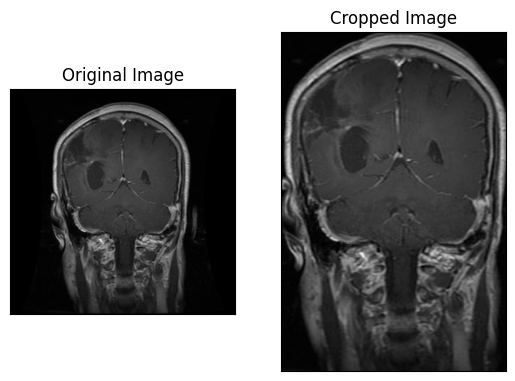

In [4]:
ex_img = cv2.imread('data/brain-tumor-mri/Training/glioma/Tr-gl_0010.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

### Choose the dataset to train and evaluate the model on

In [59]:
# Dataset 1
# augmented_path = '../../augmented data/'

# Dataset 2
# augmented_path = 'data_restructured/brain-tumor-mri/'

# Dataset 3
augmented_path = 'data_restructured/brain-tumor-classification/'

In [60]:
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1000
X shape is: (1000, 240, 240, 3)
y shape is: (1000, 1)


Each image has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [61]:
def plot_sample_images(X, y, n=9):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 3
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(9, 9))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

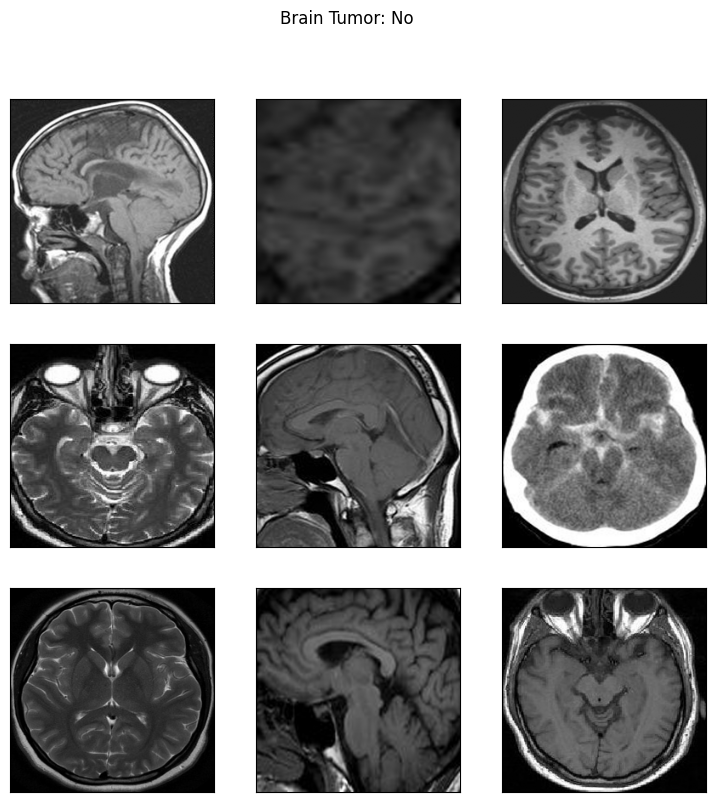

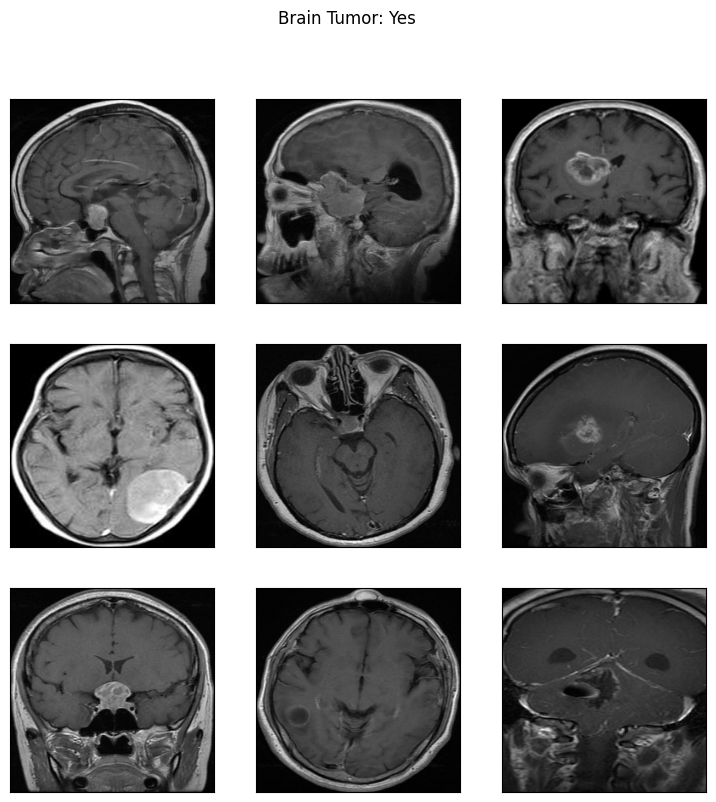

In [62]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [63]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [64]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [65]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 700
number of development examples = 150
number of test examples = 150
X_train shape: (700, 240, 240, 3)
Y_train shape: (700, 1)
X_val (dev) shape: (150, 240, 240, 3)
Y_val (dev) shape: (150, 1)
X_test shape: (150, 240, 240, 3)
Y_test shape: (150, 1)


Some helper functions:

In [66]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [67]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [68]:
def evaluate(model):
    model.metrics_names
    loss, acc = model.evaluate(x=X_test, y=y_test)
    val_loss, val_acc = model.evaluate(x=X_val, y=y_val)

    y_val_prob = model.predict(X_val)
    f1score_val = compute_f1_score(y_val, y_val_prob)

    y_test_prob = model.predict(X_test)
    f1score = compute_f1_score(y_test, y_test_prob)

    print (f"Test Loss = {loss}")
    print (f"Test Accuracy = {acc}")
    print (f"Val Loss = {val_loss}")
    print (f"Val Accuracy = {val_acc}")
    print(f"Val F1 Score: {f1score_val}")
    print(f"Test F1 Score: {f1score}")

    return y_test_prob, acc

# Build the model

Let's build a convolutional neural network model:

In [69]:
def build_model(input_shape, layer_depth, kernel_size, dropout_rate):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    for i in range(layer_depth):
        # CONV -> BN -> RELU Block applied to X
        X = Conv2D(32, (kernel_size, kernel_size), strides = (1, 1), name = f'conv{i}')(X)
        X = BatchNormalization(axis = 3, name = f'bn{i}')(X)
        X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)

    # DROPOUT
    X = Dropout(dropout_rate, name='dropout0')(X)

    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name=f'BrainDetectionModel_layer_depth_{layer_depth}_kernel_size_{kernel_size}_dropout_rate_{dropout_rate}')
    
    return model

Define the image shape:

In [70]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [71]:
model = build_model(IMG_SHAPE, layer_depth=5, kernel_size=5, dropout_rate=0.1)

In [72]:
model.summary()

Model: "BrainDetectionModel_layer_depth_5_kernel_size_5_dropout_rate_0.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 240, 240, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 240, 240, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 240, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 236, 236, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 236, 236, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 236, 236, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 232, 232, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 232, 232, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 232, 232, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 228, 228, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 228, 228, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 228, 228, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 224, 224, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,873 (437.00 KB)

 Trainable params: 111,553 (435.75 KB)

 Non-trainable params: 320 (1.25 KB)

Compile the model:

In [73]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
# Save the different dataset models
model_dir = f"models/"
os.makedirs(model_dir, exist_ok=True)

if augmented_path == '../../augmented data/':
    baseline_path = "dataset_1"
elif augmented_path == 'data_restructured/brain-tumor-mri/':
    baseline_path = "dataset_2"
else:
    baseline_path = "dataset_3"


# Static file path to ensure only the best model is saved
filepath = os.path.join(model_dir, f"baseline_{baseline_path}.keras")

# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

## Train the model

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[checkpoint], shuffle=True, verbose=1)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

## Plot Loss & Accuracy

In [75]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

### Load the model

In [76]:
best_model = load_model(filepath=f'models/baseline_{baseline_path}.keras')

In [77]:
best_model.metrics_names

['loss', 'compile_metrics']

### Accuracy and F1 Score of the model on the data:

In [78]:
y_test_prob, acc = evaluate(best_model)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7710 - loss: 0.5345
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7054 - loss: 0.6101
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Test Loss = 0.5488924384117126
Test Accuracy = 0.746666669845581
Val Loss = 0.6482433080673218
Val Accuracy = 0.6800000071525574
Val F1 Score: 0.6883116883116883
Test F1 Score: 0.7934782608695652


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [79]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [80]:
# the whole data
data_percentage(y)

Number of examples: 1000
Percentage of positive examples: 50.0%, number of pos examples: 500
Percentage of negative examples: 50.0%, number of neg examples: 500


In [81]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 700
Percentage of positive examples: 49.0%, number of pos examples: 343
Percentage of negative examples: 51.0%, number of neg examples: 357
Validation Data:
Number of examples: 150
Percentage of positive examples: 45.333333333333336%, number of pos examples: 68
Percentage of negative examples: 54.666666666666664%, number of neg examples: 82
Testing Data:
Number of examples: 150
Percentage of positive examples: 59.333333333333336%, number of pos examples: 89
Percentage of negative examples: 40.666666666666664%, number of neg examples: 61


As expected, the percentage of positive examples are around 50%.

[[39 22]
 [16 73]]


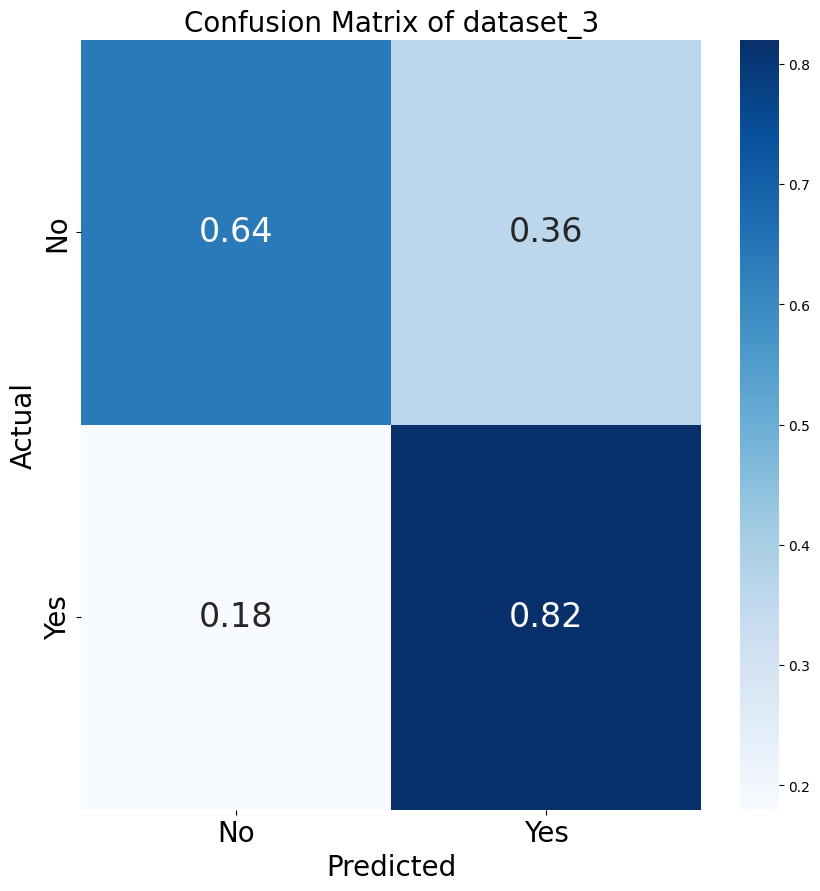

In [82]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    
    # Get confusion matrix
    cm  = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 24})
    plt.title(f'Confusion Matrix of {baseline_path}', fontsize=20)
    plt.ylabel('Actual', fontsize=20)
    plt.xlabel('Predicted', fontsize=20)
    plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'], fontsize=20)
    plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'], fontsize=20)

    # Save the confusion matrix in the plots folder
    plt.savefig(f'plots/baseline_{baseline_path}.png')
    plt.show()

y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
plot_confusion_matrix(y_test, y_test_pred)

# Analysis

### Display some of the images that were classified correctly and incorrectly:

In [ ]:
# Display some of the misclassified images
def plot_misclassified_images(X, y, y_pred):
    
    # get the indices of the misclassified examples where y_true is '1' and y_pred is '0'
    misclassified = np.where((y != y_pred) & (y == 1))[0]
    
    # choose the first 25 misclassified examples
    misclassified = misclassified[:25]
    
    columns_n = 5
    rows_n = 5

    plt.figure(figsize=(20, 20))
    
    i = 1 # current plot        
    for index in misclassified:
        plt.subplot(rows_n, columns_n, i)
        plt.imshow(X[index])
        
        # remove ticks
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        i += 1

    plt.suptitle(f"Misclassified Images")
    plt.show()

In [ ]:
plot_misclassified_images(X_test, y_test, y_test_pred)

# Conclusion

**Performance Table:**

| Metric                 | Dataset I | Dataset II| Dataset III|
|------------------------|----------------------|----------------------|----------------------|
| Accuracy (Validation)  | 0.887                | **0.955**                | 0.673                   |
| Accuracy (Test)        | 0.890                | **0.962**                | 0.800                   |
| F1 Score (Validation)  | 0.898                 | **0.958**                 | 0.703                 |
| F1 Score (Test)        | 0.897                 | **0.963**                 | 0.826                 |